# Social Network Analysis 
Written by Jin Cheong & Luke Chang


In [1]:
# Import basic packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Primer to Network Analysis

A network is made up of two main components: nodes and edges. 

The nodes are the individuals, words, or entities that compose a network, and the edges are the links that connect one node to another. 

Here is an example of a node and an edge.

<img src="Figures/nodeedge.png">

Now we can try drawing our own network using the NetworkX package.

In [2]:
# Install NetworkX
!pip install networkx
# Import NetworkX package as nx
import networkx as nx

Let's start off by initializing a Network, and call it G. 

In [3]:
# Initialize Graph object
G = nx.Graph()

Now we can add a node using the .add_node('nodename') method

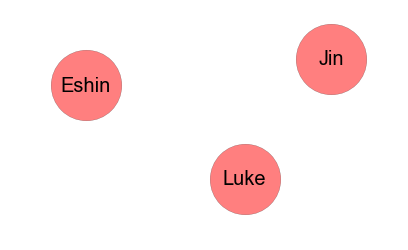

In [4]:
G = nx.Graph()
G.add_node('Jin')
G.add_node('Luke')
G.add_node('Eshin')
plt.figure(figsize=(5,3))
nx.draw(G,with_labels=True,node_size=5000,font_size=20,alpha=.5)

Notice there are no connections between the two nodes because we haven't added any edges yet.

To add edges between nodes, for example node1 and node 2, we can use the .add_edge('node1','node2') method on our graph.

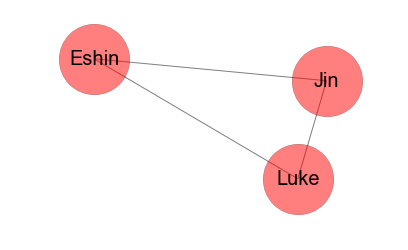

In [5]:
G = nx.Graph()
G.add_edge('Jin','Luke',weight=1)
G.add_edge('Jin','Eshin',weight=1)
G.add_edge('Luke','Eshin',weight=1)
plt.figure(figsize=(5,3))
pos = nx.spring_layout(G) # One way of specifiying a layout for nodes.
nx.draw(G,pos,with_labels=True,node_size=5000,font_size=20,alpha=.5)

Now you can see that we have an edge connecting Jin and Luke. 

Notice that we specify the weight of the edges as 1. 

If every connection is either 1 or 0, it is called an unweighted graph.  
If the edges take on other values suggesting the strength of the relationship, it is called a weighted graph.  
For simplicity, today we will only cover a unweighted graph.  

An easier way to add nodes is to use a python dictionary.
The key is the node and the values indicate what that key(node) connects to. 

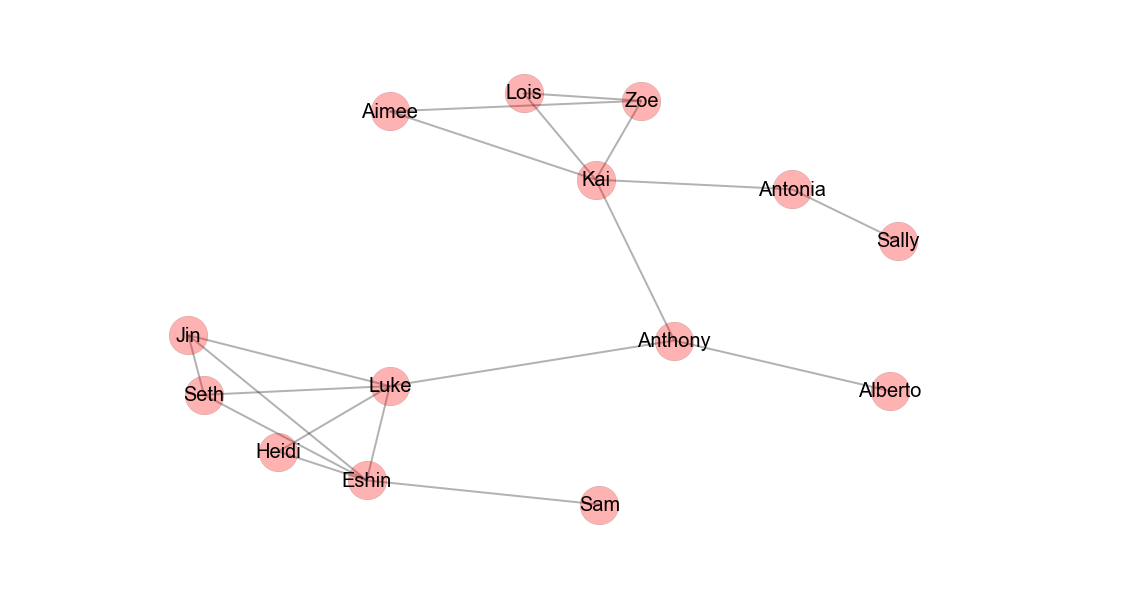

In [6]:
d = {'Jin':['Luke','Eshin','Seth'], 
     'Luke':['Eshin','Anthony','Seth','Heidi'],
     'Eshin':['Heidi','Seth','Sam'],
     'Zoe':['Kai','Aimee','Lois'],
     'Kai':['Antonia','Aimee','Lois','Anthony'],
     'Sally':['Antonia'],
     'Anthony':['Alberto']}
G = nx.Graph(d)
plt.figure(figsize=(15,8))
np.random.seed(3) # Just to keep things same
pos = pos = nx.fruchterman_reingold_layout(G) # Another way of specifiying a layout for nodes.
nx.draw(G,with_labels=True,node_size=1500,font_size=20,alpha=.3,width=2)

# What should we look for in a network ? 

## Micromeasures
Centrality measures track the importance of a node derived from its position in the network.

There are four main groups of centrality depending on the type of statistics used:
1. degree - how connected a node is
2. betweenness - how important a node is in connecting other nodes
3. closeness - how easily a node can reach other nodes
4. neighbors' characteristics - how important, central, or influential a node's neighbors are. 

<img src="Figures/centrality.png",width=300>

Reference:
Social and Economic Networks by Matthew O. Jackson. Princeton University Press.   
Picture: [Wikipedia article](https://en.wikipedia.org/wiki/Centrality)   
Other examples: http://www.orgnet.com/sna.html  

## Degree Centrality

The degree centrality measures the number of edges of a given node. 

In other words, it measures how connected a node is.

Degree Centrality Map
Antonia         0.154                         
Zoe             0.231                         
Sam             0.077                         
Jin             0.231                         
Luke            0.385                         
Kai             0.385                         
Seth            0.231                         
Lois            0.154                         
Anthony         0.231                         
Aimee           0.154                         
Alberto         0.077                         
Heidi           0.154                         
Sally           0.077                         
Eshin           0.385                         


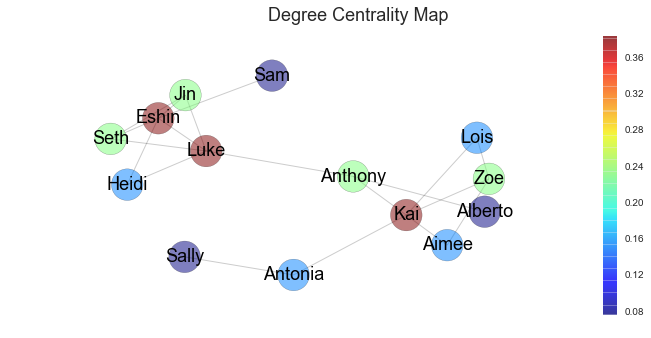

In [7]:
def print_network(val_map,title=None):
    print('\x1b[1;31m'+title+'\x1b[0m')
    for k, v in val_map.iteritems():
        print k.ljust(15), str(round(v,3)).ljust(30)

def plot_network(val_map, title=None):
    values = [val_map.get(node, 0.25) for node in G.nodes()]
    plt.figure(figsize=(12,5))
    np.random.seed(2)
#     pos = nx.spring_layout(G)
    pos = nx.fruchterman_reingold_layout(G,dim=2)
    ec = nx.draw_networkx_edges(G,pos,alpha=.2)
    nc = nx.draw_networkx_nodes(G,pos,node_size=1000,with_labels=True,alpha=.5,cmap=plt.get_cmap('jet'),node_color=values)
    nx.draw_networkx_labels(G,pos,font_size=18)
    # nx.draw(G,pos,node_size=400,with_labels=True,alpha=.5,cmap=plt.get_cmap('jet'),node_color=values)
    plt.colorbar(nc)
    plt.axis('off')
    plt.suptitle(title,fontsize=18)
    plt.show()

# Get degree centrality values
d = nx.degree_centrality(G)
title = 'Degree Centrality Map'
# print centrality values
print_network(d,title)
# plot graph with values
plot_network(d,title)

If we look at degree centrality, Luke, Kai, and Eshin all have 5 edges, resulting in the same number of degree centrality.

# Betweenness Centrality
Think of Between Centrality as a bottleneck or a broker of two separate networks. 

The measure is the fraction of the total number of shortest paths a node lie on between two other nodes.

The betweenness is 1 for Anthony in the path between Alberto and Kai. 
The betweenness is .5 for Zoe in the path between Lois and Aimee (because Lois can alternatively go through Kai).

Observe that Anthony has the highest Betweenness Centrality and can be considered the most central member of the network.

Betweenness Centrality
Antonia         0.154                         
Zoe             0.006                         
Sam             0.0                           
Jin             0.0                           
Luke            0.526                         
Kai             0.596                         
Seth            0.0                           
Lois            0.0                           
Anthony         0.615                         
Aimee           0.0                           
Alberto         0.0                           
Heidi           0.0                           
Sally           0.0                           
Eshin           0.167                         


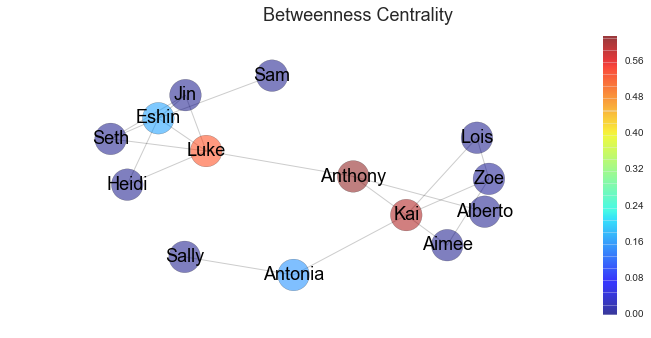

In [8]:
d = nx.betweenness_centrality(G)
title = "Betweenness Centrality"
print_network(d,title)
plot_network(d,title)

# Closeness Centrality
The closeness centrality measures how close a given node is to any other node.

Closeness Centrality
Antonia         0.351                         
Zoe             0.351                         
Sam             0.283                         
Jin             0.361                         
Luke            0.481                         
Kai             0.481                         
Seth            0.361                         
Lois            0.342                         
Anthony         0.52                          
Aimee           0.342                         
Alberto         0.351                         
Heidi           0.351                         
Sally           0.265                         
Eshin           0.382                         


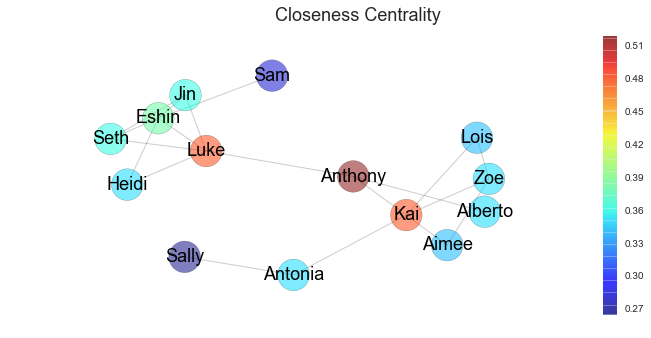

In [9]:
d = nx.closeness_centrality(G)
title = "Closeness Centrality"
print_network(d,title)
plot_network(d,title)

# Eigenvector Centrality

The underlying assumption of the Eigenvector centrality is that a node's importance is determined by how important its neighbors are.  

Now we can observe that Luke is back to being more important than Anthony.

, because Luke is friends with Eshin who also has high

Eigenvector Centrality
Anthony         0.192                         
Antonia         0.034                         
Jin             0.404                         
Seth            0.404                         
Aimee           0.047                         
Zoe             0.058                         
Alberto         0.055                         
Heidi           0.288                         
Luke            0.51                          
Kai             0.108                         
Sally           0.01                          
Sam             0.143                         
Eshin           0.499                         
Lois            0.047                         


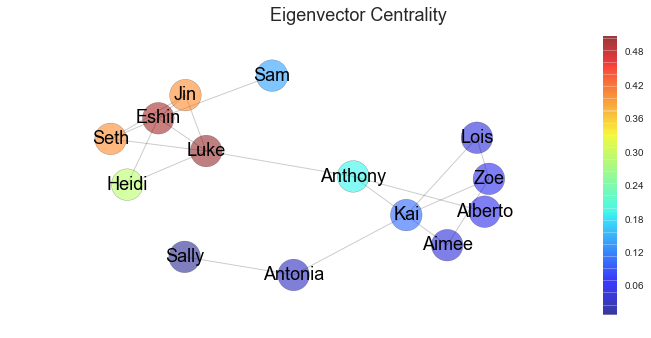

In [10]:
d = nx.eigenvector_centrality(G)
title = "Eigenvector Centrality"
print_network(d,title)
plot_network(d,title)

## Macromeasures

Macromeasures are useful to understand the network as a whole or to compare networks. 

We will cover three fundamental measures of the network structure.
1. Degree distribution
2. Average shortest path 
3. Clustering Coefficients

## Degree Distribution
One fundamental characteristic is the distribution of degrees, number of edges for each node, which we can easily plot.  
From this distribution we can discern attributes such as whether everyone is connected to everybody are there many lonely nodes and such.

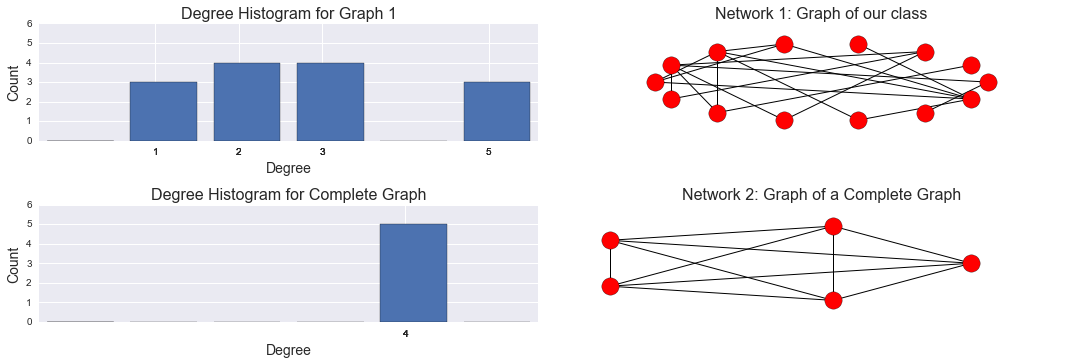

In [11]:
degree_sequence=sorted([d for n,d in G.degree().iteritems()], reverse=True) # degree sequence

G2=nx.complete_graph(5)
degree_sequence2=sorted([d for n,d in G2.degree().iteritems()], reverse=True) # degree sequence

fig, [(ax1,ax2),(ax3,ax4)] = plt.subplots(2,2,figsize=(15,5))
ax1.hist(degree_sequence,bins=range(0,7),rwidth=.8)
ax1.set_title("Degree Histogram for Graph 1",fontsize=16)
ax1.set_ylabel("Count",fontsize=14)
ax1.set_xlabel("Degree",fontsize=14)
ax1.set_xticks([d+0.4 for d in degree_sequence])
ax1.set_xticklabels([d for d in degree_sequence])
ax1.set_ylim((0,6))

nx.draw(G,pos=nx.circular_layout(G),ax=ax2)
ax2.set_title('Network 1: Graph of our class',fontsize=16)

ax3.hist(degree_sequence2,bins=range(0,7),rwidth=.8)
ax3.set_title("Degree Histogram for Complete Graph",fontsize=16)
ax3.set_ylabel("Count",fontsize=14)
ax3.set_xlabel("Degree",fontsize=14)
ax3.set_xticks([d+0.4 for d in degree_sequence2])
ax3.set_xticklabels([d for d in degree_sequence2])
ax3.set_ylim((0,6))

nx.draw(G2,pos=nx.circular_layout(G2),ax=ax4)
ax4.set_title('Network 2: Graph of a Complete Graph',fontsize=16)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

## Average Shortest Path

The average shortest path length is the average of calculating the shortest number of edges it takes for every pair of nodes in the network.  

This can be a mesure of how efficient/fast the network is in the distribution of information, rumors, disease, etc.

In [12]:
print 'Network 1 average shortest path: ' + str(round(nx.average_shortest_path_length(G),2))
print 'Network 2 average shortest path: ' + str(nx.average_shortest_path_length(G2))

Network 1 average shortest path: 2.77
Network 2 average shortest path: 1.0


## Clustering coefficient. 

Another way to look at how tight-knit a network is to look at how clustered it is.   
To estimate clustering, we start from cliques, which can be considered as a subnetwork composed of three nodes forming a triangle. 

We can first calculate for each node, how many cliques(triangles) it is a member of.  
Then we calculate transitivity, which is simply the number of triangles in the network divided by the number of all possible traingles.

Number of cliques(triangles)
Antonia         0.0                           
Zoe             2.0                           
Sam             0.0                           
Jin             3.0                           
Luke            4.0                           
Kai             2.0                           
Seth            3.0                           
Lois            1.0                           
Anthony         0.0                           
Aimee           1.0                           
Alberto         0.0                           
Heidi           1.0                           
Sally           0.0                           
Eshin           4.0                           

Transitivity : 0.45652173913


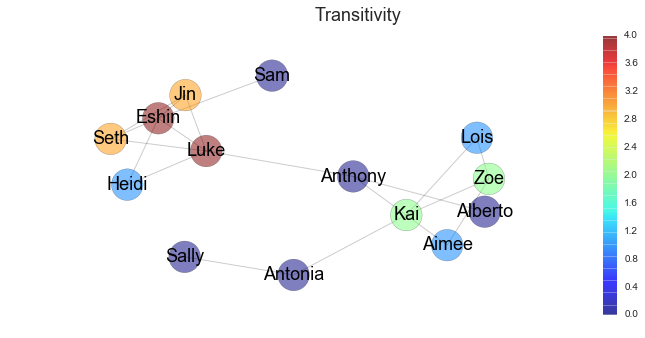

In [13]:
d = nx.triangles(G)
print_network(d,'Number of cliques(triangles)')
print 
print 'Transitivity : ' + str(nx.transitivity(G))

plot_network(d,'Transitivity')

A similar approach is to calculate clustering coefficient for each node and for the graph.
Clustering is the measure of how likely it is if A has edges to B and C, that B and C related? 

For instance, Zoe has 3 edges to Lois, Kai, Aimee.  
Zoe-Lois-Kai form a triangle(+1) and Zoe-Aimee-Kai form a triangle(+1) BUT Zoe-Aimee-Lois does not form a triangle(+0).  
Therefore Zoe's clustering coefficient is 2/3.

We can calculate this for each node and then get an average value overall to get the average clustering coefficient.

In [14]:
d = nx.clustering(G)
print_network(d,'Clustering Coefficients per node')
print 
print 'Average clustering coefficient : ' + str(nx.average_clustering(G))

Clustering Coefficients per node
Antonia         0.0                           
Zoe             0.667                         
Sam             0.0                           
Jin             1.0                           
Luke            0.4                           
Kai             0.2                           
Seth            1.0                           
Lois            1.0                           
Anthony         0.0                           
Aimee           1.0                           
Alberto         0.0                           
Heidi           1.0                           
Sally           0.0                           
Eshin           0.4                           

Average clustering coefficient : 0.47619047619
